# Download data

Data is 25K .jpg images from two existing datasets.

- images.csv metadata from Unsplash, sorted and converted to CSV.
- images/ in 250x250 resolution by kaggle/@jettchentt.
- images.fbin is a binary file with UForm image embeddings.
- images.usearch is a binary file with a serialized USearch index.
The original images.tsv from Unsplash has been filtered to avoid missing images.

👉🏼 Download `images.zip` file directly from: <br>
https://huggingface.co/datasets/unum-cloud/ann-unsplash-25k/tree/main 

In [1]:
import glob, time, pprint
import numpy as np
from PIL import Image
import pandas as pd

# Load image files and descriptions
image_data = pd.read_csv('images.csv')
print(image_data.shape)
display(image_data.head(2))

# List of image urls and texts.
image_urls = list(image_data.photo_id)
image_texts = list(image_data.ai_description)

(24292, 31)


,photo_id,photo_url,photo_image_url,photo_submitted_at,photo_featured,photo_width,photo_height,photo_aspect_ratio,photo_description,photographer_username,...,photo_location_country,photo_location_city,stats_views,stats_downloads,ai_description,ai_primary_landmark_name,ai_primary_landmark_latitude,ai_primary_landmark_longitude,ai_primary_landmark_confidence,blur_hash
0,__1Mu7EZXOM,https://unsplash.com/photos/__1Mu7EZXOM,https://images.unsplash.com/photo-149356066022...,2017-04-30 13:58:01.366011,t,3326,4157,0.80,NaN,thesollers,...,NaN,NaN,1215372,6169,brown leaves during daytime,NaN,NaN,NaN,NaN,LODL1l]3K6s:2{FzOFN_MxWBwaoK
1,__CmMNKO4nw,https://unsplash.com/photos/__CmMNKO4nw,https://images.unsplash.com/photo-157617584472...,2019-12-12 18:39:47.405498,t,3456,5184,0.67,NaN,ericmuhr,...,NaN,NaN,480356,1087,curve road on hill,Historic Columbia River Highway,45.682408,-121.299534,0.707863,LgJkiikWxajs?wWVWBay~Xofj?j[


# Create a Milvus Collection

In [2]:
# STEP 1. CONNECT TO MILVUS STANDALONE DOCKER.
import pymilvus

# print(f"Pymilvus: {pymilvus.__version__}") #2.4.3
# !wget https://github.com/milvus-io/milvus/releases/download/v2.4.1/milvus-standalone-docker-compose.yml -O docker-compose.yml

import pymilvus, time
from pymilvus import (
    MilvusClient, utility, connections,
    FieldSchema, CollectionSchema, DataType, IndexType,
    Collection, AnnSearchRequest, RRFRanker, WeightedRanker
)
print(f"Pymilvus: {pymilvus.__version__}")

# Start the Milvus server.
# !docker compose up -d

# Connect to the local server.
connection = connections.connect(
  alias="default", 
  host='localhost', # or '0.0.0.0' or 'localhost'
  port='19530'
)

# Get server version.
print(f"Milvus server: {utility.get_server_version()}")

Pymilvus: 2.4.3
Milvus server: v2.4.1


In [3]:
# STEP 2. CREATE A COLLECTION

EMBEDDING_DIM = 256
MAX_LENGTH = 65535

# Specify the data schema for the new Collection.
fields = [
    # Use auto generated id as primary key
    FieldSchema(name="id", dtype=DataType.INT64,
                is_primary=True, auto_id=True, max_length=100),
    FieldSchema(name="text_vector", dtype=DataType.FLOAT_VECTOR,
                dim=EMBEDDING_DIM),
    FieldSchema(name="image_vector", dtype=DataType.FLOAT_VECTOR,
                dim=EMBEDDING_DIM),
    FieldSchema(name="chunk", dtype=DataType.VARCHAR, max_length=MAX_LENGTH),
    FieldSchema(name="image_filepath", dtype=DataType.VARCHAR, max_length=MAX_LENGTH),
]
schema = CollectionSchema(fields, "")

# Set the Milvus collection name.
COLLECTION_NAME = "Demo_multimodal"

# Check if collection already exists, if so drop it.
has = utility.has_collection(COLLECTION_NAME)
if has:
    drop_result = utility.drop_collection(COLLECTION_NAME)
    print(f"Successfully dropped collection: `{COLLECTION_NAME}`")

# Create the collection.
schema = CollectionSchema(fields, "")
col = Collection(COLLECTION_NAME, schema, consistency_level="Eventually")
# Create indixes using AUTOINDEX. 
image_index = {"metric_type": "COSINE"}
text_index = {"metric_type": "COSINE"}
col.create_index("image_vector", image_index)
col.create_index("text_vector", text_index)
col.load()

print(f"Successfully created collection: `{COLLECTION_NAME}`")

Successfully dropped collection: `Demo_multimodal`
Successfully created collection: `Demo_multimodal`


# Inference the embedding model

Using [Unum's UForm](https://huggingface.co/collections/unum-cloud/uform-3-encoders-662344ee44bc96a4aa5937cd) Pocket-Sized Multimodal Encoders.

Supports text-to-image queries in 21 languages including:
English
German
Spanish
French
Italian
Russian
Japanese
Korean
Turkish
Chinese
Polish.

In [4]:
# !python -m pip install -U "uform[torch,onnx]"
# !python -m pip install -U torch

In [5]:
import sys
sys.path.append("./")  
import multimodal as _mm

# Initialize a multi-modal embedding model.
model_name = "unum-cloud/uform3-image-text-multilingual-base"
embedding_model = _mm.ComputeEmbeddings(model_name)

2024-05-28 20:22:01.881705 [W:onnxruntime:, helper.cc:67 IsInputSupported] CoreML does not support input dim > 16384. Input:word_embeddings.weight_quantized, shape: {250037,384}
2024-05-28 20:22:01.882543 [W:onnxruntime:, coreml_execution_provider.cc:81 GetCapability] CoreMLExecutionProvider::GetCapability, number of partitions supported by CoreML: 74 number of nodes in the graph: 714 number of nodes supported by CoreML: 483
2024-05-28 20:22:03.051915 [W:onnxruntime:, coreml_execution_provider.cc:81 GetCapability] CoreMLExecutionProvider::GetCapability, number of partitions supported by CoreML: 100 number of nodes in the graph: 1056 number of nodes supported by CoreML: 727


In [6]:
import requests
from PIL import Image
from io import BytesIO

# Run this in small batches to avoid memory issues.
BATCH_SIZE = 10

# Batch embed text and images and insert data into Milvus.
failed_indices = []
for i in range(0, 300, BATCH_SIZE):
# for i in range(0, len(image_texts), BATCH_SIZE):
    batch_images = []
    batch_texts = []
    batch_urls = []
    for j in range(BATCH_SIZE):
        if i + j < len(image_texts):
            text = image_texts[i + j]
            url = image_urls[i + j]
            # Check if the url is a web url or a local file.
            if url.startswith("https://"):
                response = requests.get(url)
                try:
                    with Image.open(BytesIO(response.content)) as img:
                        batch_images.append(img.copy())
                        batch_texts.append(text)
                        batch_urls.append(url)
                except:
                    print(f"Image error: {url}")
                    failed_indices.append(i + j)
            else:
                try:
                    with Image.open(f"./images/{url}.jpg") as img:
                        batch_images.append(img.copy())
                        batch_texts.append(text)
                        batch_urls.append(url)
                except:
                    print(f"Image error: ./images/{url}.jpg")
                    failed_indices.append(i + j)

    # Permanently remove the failed indices.
    for index in sorted(failed_indices, reverse=True):
        del image_texts[index]
        del image_urls[index]

    # STEP 3. EMBEDDING INFERENCE FOR TEXT AND IMAGES.
    start_time = time.time()
    image_embeddings, text_embeddings = embedding_model(
        batch_images=batch_images,
        batch_texts=batch_texts)
    end_time = time.time()
    print(f"Embedding time for batch size {len(batch_images)}: ", end="")
    print(f"{np.round(end_time - start_time, 2)} seconds")

    # Create chunk dict_list.
    chunk_dict_list = []
    for chunk, img_url, img_embed, text_embed in zip(
        batch_texts, 
        batch_urls,
        image_embeddings, text_embeddings):

        # Assemble embedding vector, original text chunk, metadata.
        chunk_dict = {
            'chunk': chunk,
            'image_filepath': img_url,
            'text_vector': text_embed,
            'image_vector': img_embed
        }
        chunk_dict_list.append(chunk_dict)

    # STEP 4. INSERT CHUNK LIST INTO MILVUS OR ZILLIZ.
    start_time = time.time()
    col.insert(
        data=chunk_dict_list)

    end_time = time.time()
    # print(f"Insert time for {len(chunk_dict_list)} vectors: ", end="")
    # print(f"{np.round(end_time - start_time, 4)} seconds")

col.flush()

Context leak detected, msgtracer returned -1
Context leak detected, msgtracer returned -1
Context leak detected, msgtracer returned -1
Context leak detected, msgtracer returned -1


Embedding time for batch size 10: 5.01 seconds
Embedding time for batch size 10: 4.25 seconds
Embedding time for batch size 10: 5.03 seconds
Embedding time for batch size 10: 4.65 seconds
Embedding time for batch size 10: 4.88 seconds
Embedding time for batch size 10: 5.41 seconds
Embedding time for batch size 10: 5.39 seconds
Embedding time for batch size 10: 4.47 seconds
Embedding time for batch size 10: 2.64 seconds
Image error: ./images/_bQFVR3DF68.jpg
Embedding time for batch size 9: 4.45 seconds
Embedding time for batch size 10: 5.61 seconds
Embedding time for batch size 10: 5.26 seconds
Embedding time for batch size 10: 5.29 seconds
Embedding time for batch size 10: 4.98 seconds
Image error: ./images/_GZBJppR7Hk.jpg
Embedding time for batch size 9: 3.66 seconds
Embedding time for batch size 10: 4.44 seconds
Embedding time for batch size 10: 4.2 seconds
Embedding time for batch size 10: 3.33 seconds
Embedding time for batch size 10: 4.53 seconds
Embedding time for batch size 10: 

In [7]:
# Save metadata fields for search filtering.
OUTPUT_FIELDS = list(chunk_dict_list[0].keys())
OUTPUT_FIELDS.remove('text_vector')
OUTPUT_FIELDS.remove('image_vector')
OUTPUT_FIELDS.insert(0, "id")
print(f"output fields: {OUTPUT_FIELDS}")

# print(len(chunk_dict_list))
# print(len(chunk_dict_list[0]))
# pprint.pprint(chunk_dict_list[0])

output fields: ['id', 'chunk', 'image_filepath']


black and white nike athletic shoe


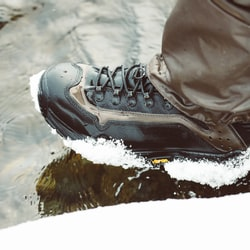

green leafed plant


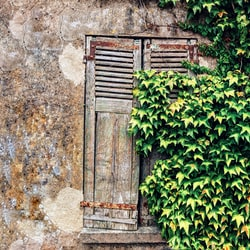

red rose flowers


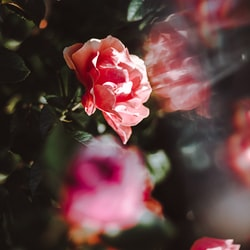

a white dog sitting in the snow looking at the camera


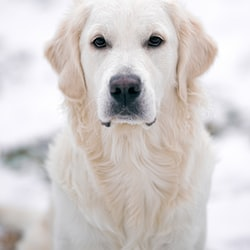

cloudy sky during golden hour


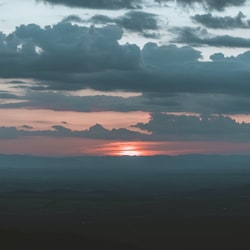

selective focus photography of waterfalls during daytime


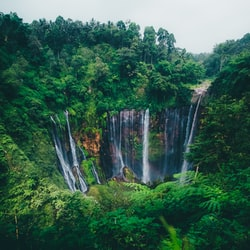

a close up of a cat with an open mouth


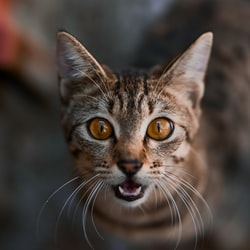

bird's-eye photography of pine trees covered by snow


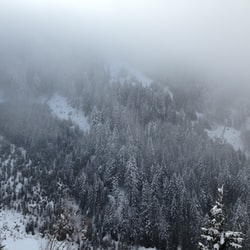

grey mountains during sunset


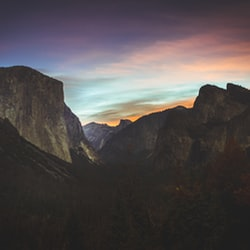

woman with wings willow tree figurine


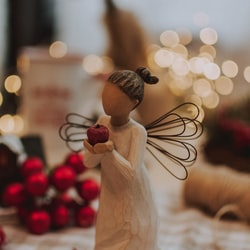

In [8]:
# View sample images and texts.
BATCH_SIZE = 10

i = BATCH_SIZE*7
for url in image_urls[BATCH_SIZE*7:BATCH_SIZE*8]:
    # Check if the url is a web url or a local file.
    if url.startswith("https://"):
        response = requests.get(url)
        with Image.open(BytesIO(response.content)) as img:
            batch_images.append(img.copy())
    else:
        with Image.open(f"./images/{url}.jpg") as img:
            print(image_texts[i])
            display(img)
    i += 1

# Now the fun part, search!

In [9]:
# Count DB rows.
start_time = time.time()
print(f"Count rows: {col.num_entities}")
end_time = time.time()
print(f"timing: {np.round(end_time - start_time, 4)} seconds")
print()

col.load()

Count rows: 298
timing: 0.0066 seconds



In [10]:
# Define a sample question about your data.
QUESTION1 = "brown leaves during daytime"
# QUESTION1 = "feuilles brunes pendant la journée"
QUESTION2 = "silhouette of person sitting on rock formation during golden hour"
# QUESTION2 = "silhouette d'une personne assise sur une roche au couche du soleil"
QUESTION3 = "a tabby cat"
QUESTION3 = "un chat tigré"
QUESTION4 = "a cityscape bathed in the warm glow of the sun, with varied architecture and a towering, snow-capped mountain rising majestically in the background"

a close up of a cat with an open mouth


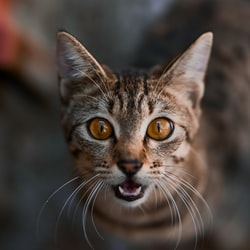

In [11]:
# SELECT A PARTICULAR QUESTION TO ASK.
SAMPLE_QUESTION = "feuilles brunes pendant la journée"

# SELECT A PARTICULAR IMAGE TO REVERSE SEARCH.
url = image_urls[76]
with Image.open(f"./images/{url}.jpg") as img:
            print(image_texts[76])
            SAMPLE_IMAGE = img.copy()
            display(SAMPLE_IMAGE)

Milvus search time: 0.0044231414794921875 seconds


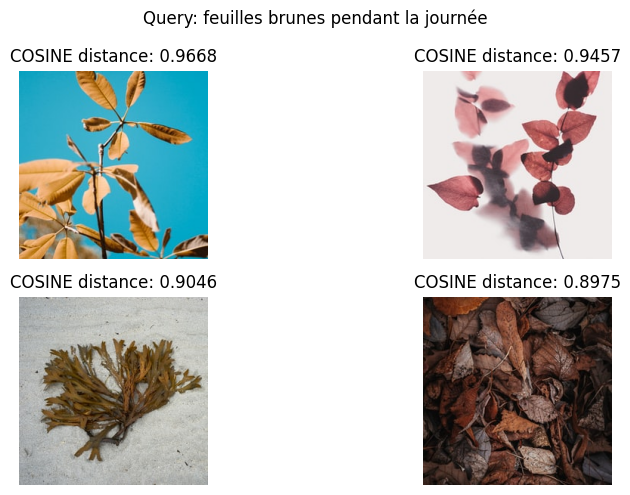

In [17]:
# Run multimodal search using text query only.
results = _mm.multi_modal_search(SAMPLE_QUESTION, SAMPLE_IMAGE, 
                       embedding_model, 
                       col, OUTPUT_FIELDS,
                       text_only=True, 
                       image_only=False,
                       top_k=4)

Milvus search time: 0.0057070255279541016 seconds


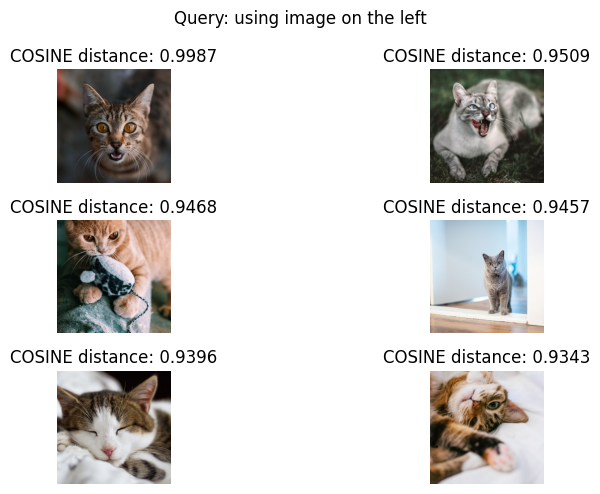

In [16]:
# Run multimodal search using reverse image search only.
results = _mm.multi_modal_search(SAMPLE_QUESTION, SAMPLE_IMAGE, 
                       embedding_model, 
                       col, OUTPUT_FIELDS,
                       text_only=False, 
                       image_only=True,
                       top_k=6)

silhouette of person sitting on rock formation during golden hour


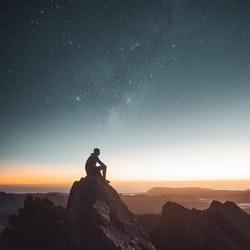

In [19]:
# SELECT A PARTICULAR QUESTION TO ASK.
SAMPLE_QUESTION = "silhouette d'une personne assise sur une roche au couche du soleil"

# SELECT A PARTICULAR IMAGE TO REVERSE SEARCH.
url = image_urls[3]
with Image.open(f"./images/{url}.jpg") as img:
            print(image_texts[3])
            SAMPLE_IMAGE = img.copy()
            display(SAMPLE_IMAGE)

Milvus search time: 0.004724025726318359 seconds


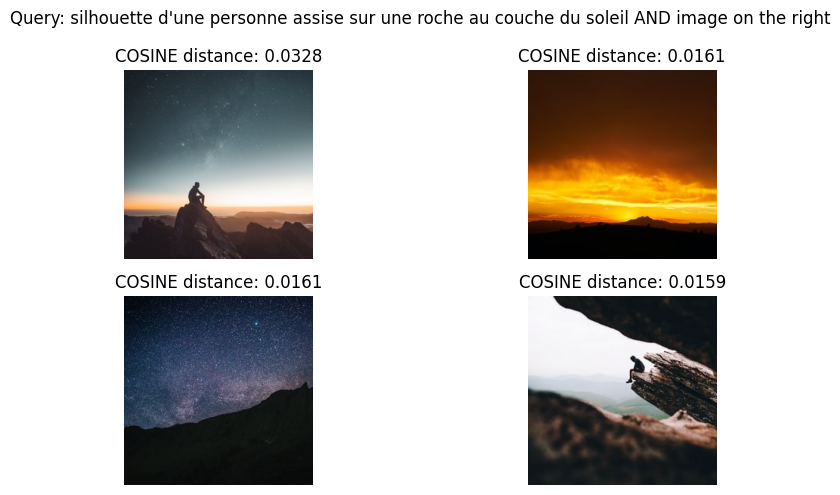

In [21]:
# Doesn't make sense unrelated text AND image search.
results = _mm.multi_modal_search(SAMPLE_QUESTION, SAMPLE_IMAGE, 
                       embedding_model, 
                       col, OUTPUT_FIELDS,
                       text_only=False, 
                       image_only=False,
                       top_k=4)

<Figure size 640x480 with 0 Axes>

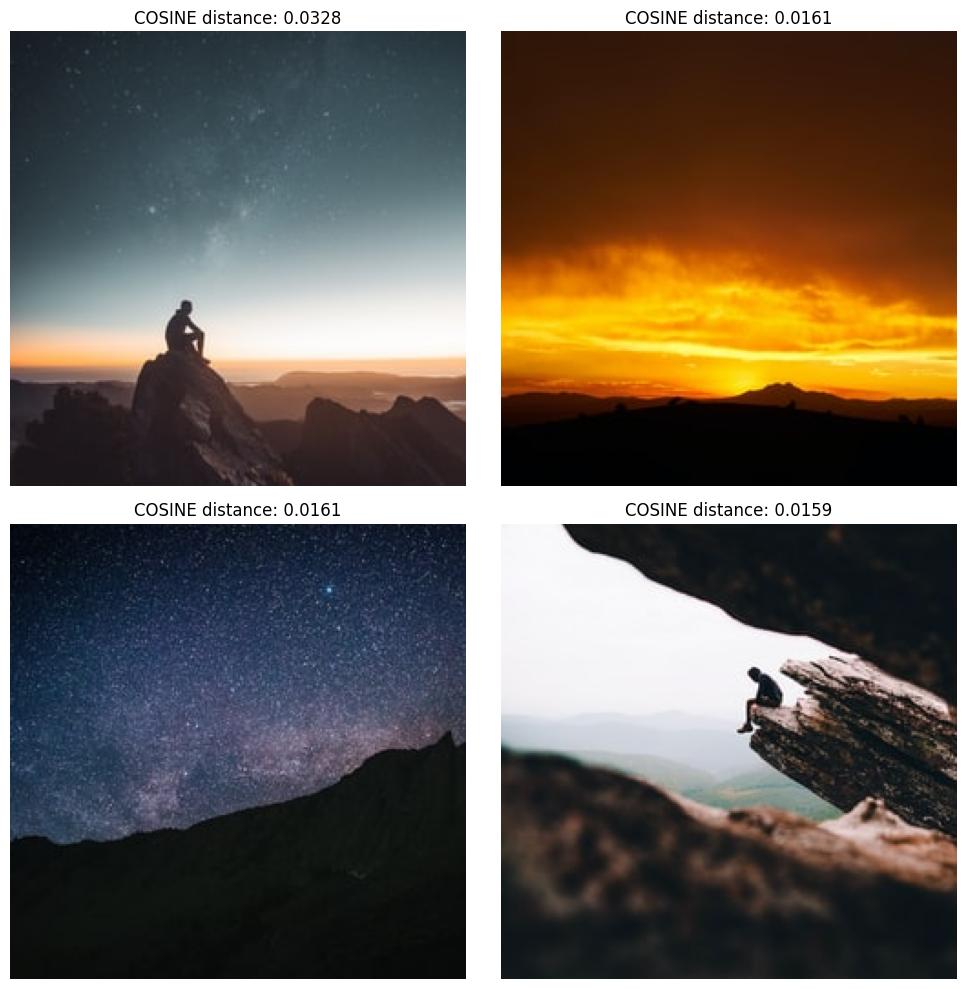

In [27]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

top_k=4

# Display the images 2x2.
plt.suptitle(f"Query: {SAMPLE_QUESTION} AND image on the right")

# Display 2x2 grid of images.
num_rows = int(round(top_k/2,0))
plt.figure(figsize=(10,10))
for i, result in enumerate(results):
    with Image.open(f"./images/{result.entity.image_filepath}.jpg") as img:
        plt.subplot(num_rows, 2, i+1)
        plt.imshow(img)
        plt.title(f"COSINE distance: {round(result.distance,4)}")
        plt.axis('off')
plt.tight_layout()
plt.show()

In [15]:
# Props to Sebastian Raschka for this handy watermark.
# !pip install watermark

%load_ext watermark
%watermark -a 'Christy Bergman' -v -p torch,pymilvus,uform --conda

Author: Christy Bergman

Python implementation: CPython
Python version       : 3.11.8
IPython version      : 8.22.2

torch   : 2.3.0
pymilvus: 2.4.3
uform   : 3.0.2

conda environment: py311-unum

